In [154]:
from typing import List, Tuple
from helper.helper_functions import load_dataset, save_model, get_features_and_target, encode_all_features
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.neighbors import KNeighborsClassifier

In [155]:
from sklearn.model_selection import GridSearchCV
# https://medium.com/@agrawalsam1997/hyperparameter-tuning-of-knn-classifier-a32f31af25c7
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

def tune_knn(X_encoded: pd.DataFrame, y_encoded: pd.Series, X_test, y_test) -> Tuple[dict, KNeighborsClassifier, float]:
    """
    Tune the hyperparameters of the K-Nearest Neighbors model using GridSearchCV.
    :param X_encoded: 
    :param y_encoded: 
    :param X_test: 
    :param y_test: 
    :return: 
    """
    # Define the hyperparameter grid
    param_grid = {
        'n_neighbors': np.arange(2, 30, 1),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
    
    knn = KNeighborsClassifier()
    
    # Perform grid search with 5-fold cross-validation
    knn_cv = GridSearchCV(knn, param_grid=param_grid, cv=5, verbose=1)
    
    knn_cv.fit(X_encoded, y_encoded)
    
    best_params = knn_cv.best_params_ # best hyperparameters
    best_model = knn_cv.best_estimator_ # best model
    
    accuracy = best_model.score(X_test, y_test)
    
    return best_params, best_model, accuracy

In [156]:
def forward_feat_selection_hypertuning(X_encoded: pd.DataFrame, y_encoded: pd.Series) -> Tuple[List[str], dict, float]:
    """
    Forward feature selection with hyperparameter tuning for K-Nearest Neighbors.
    :param X_encoded: features dataset, with features encoded
    :param y_encoded: target dataset, with target encoded
    :return: (best subset of features, best hyperparameters, best model accuracy)
    """
    best_subset: List[str] = []
    best_params: dict = None
    best_score: float = 0.0
    
    remaining_features = [['age'], 
                          ['education'], 
                          ['workinghours'],
                          [col for col in X_encoded.columns if col.startswith('workclass')],
                          [col for col in X_encoded.columns if col.startswith('marital status')],
                          [col for col in X_encoded.columns if col.startswith('occupation')]]
    
    while remaining_features:
        subset_scores = []
        subset_params = []
    
        for feature_cat in remaining_features:
            # Combine the current best subset with the new feature
            current_subset = best_subset + feature_cat if best_subset else feature_cat.copy()
            
            X_subset = X_encoded[current_subset]
            X_train, X_val, y_train, y_val = train_test_split(X_subset, y_encoded, test_size=0.2, random_state=42)
            
            best_params, best_model, score = tune_knn(X_subset, y_encoded, X_val, y_val)
            
            subset_scores.append(score)
            subset_params.append(best_params)
            
        # Select the feature that improves performance the most
        best_index = subset_scores.index(max(subset_scores))
        best_score = subset_scores[best_index]
        best_params = subset_params[best_index]
        best_feature = remaining_features[best_index]
        
        # Update the best subset and remaining features
        best_subset = best_subset + best_feature if best_subset else best_feature.copy()
        del remaining_features[best_index]
        
        print("Best subset:", best_subset)
        print("Remaining features:", remaining_features)
        
    return best_subset, best_params, best_score

### Loading the cleaned dataset

In [157]:
data = load_dataset('../data/assignment2_income_cleaned.xlsx')

In [158]:
# Splitting the data into features (X) and target (y)
X, y = get_features_and_target(data, 'income')
columns_to_exclude = ['sex', 'ability to speak english', 'gave birth this year']
# Encoding the features and target, and excluding some columns
X_encoded, y_encoded = encode_all_features(X, y, columns_to_exclude)
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

### Model

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [159]:
# K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [160]:
# Predictions
knn_preds = knn_model.predict(X_test)
# Accuracy evaluation
knn_accuracy = accuracy_score(y_test, knn_preds)

print(classification_report(y_test, knn_preds))
print("K-Nearest Neighbors Accuracy:", knn_accuracy)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1175
           1       0.62      0.63      0.62       625

    accuracy                           0.74      1800
   macro avg       0.71      0.71      0.71      1800
weighted avg       0.74      0.74      0.74      1800

K-Nearest Neighbors Accuracy: 0.7366666666666667


In [161]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#:~:text=This%20Sequential%20Feature%20Selector%20adds,validation%20score%20of%20an%20estimator.

# Create KNN classifier
knn = KNeighborsClassifier()

# Create Sequential Feature Selector
sfs = SequentialFeatureSelector(knn, 
                                 direction="backward", # backward feature elimination
                                 scoring='accuracy',
                                 cv=StratifiedKFold())

# Fit the feature selector to training data
sfs.fit(X_train, y_train)

# Get selected features and feature indices
selected_features = sfs.get_support()
selected_feature_indices = [i for i, val in enumerate(selected_features) if val]

print("Selected features:")
for i, feature in enumerate(X_train.columns[selected_feature_indices]):
    print(f"Feature {i+1}: {feature}")

Selected features:
Feature 1: education
Feature 2: workinghours
Feature 3: workclass_governmental
Feature 4: marital status_Husband
Feature 5: marital status_Never married
Feature 6: marital status_Widowed
Feature 7: occupation_Construction/Extraction
Feature 8: occupation_Education
Feature 9: occupation_Finance/Accounting
Feature 10: occupation_Healthcare/Medical Services
Feature 11: occupation_Management/Business
Feature 12: occupation_Office/Administrative Support
Feature 13: occupation_Protective Services
Feature 14: occupation_Repair/Maintenance
Feature 15: occupation_Sales
Feature 16: occupation_Science, Engineering, Technology


### Hyperparameter tuning

In [162]:
tune = False
if tune:
    best_params, best_model, best_accuracy = tune_knn(X_train, y_train, X_test, y_test)
    
    print("Best Hyperparameters:", best_params)
    print("Best Model:", best_model)
    print("Best Model Accuracy:", best_accuracy)

Best Hyperparameters: {'n_neighbors': 28, 'p': 1, 'weights': 'uniform'}, Best Model Accuracy: 0.7777777777777778

https://www.geeksforgeeks.org/feature-selection-techniques-in-machine-learning/


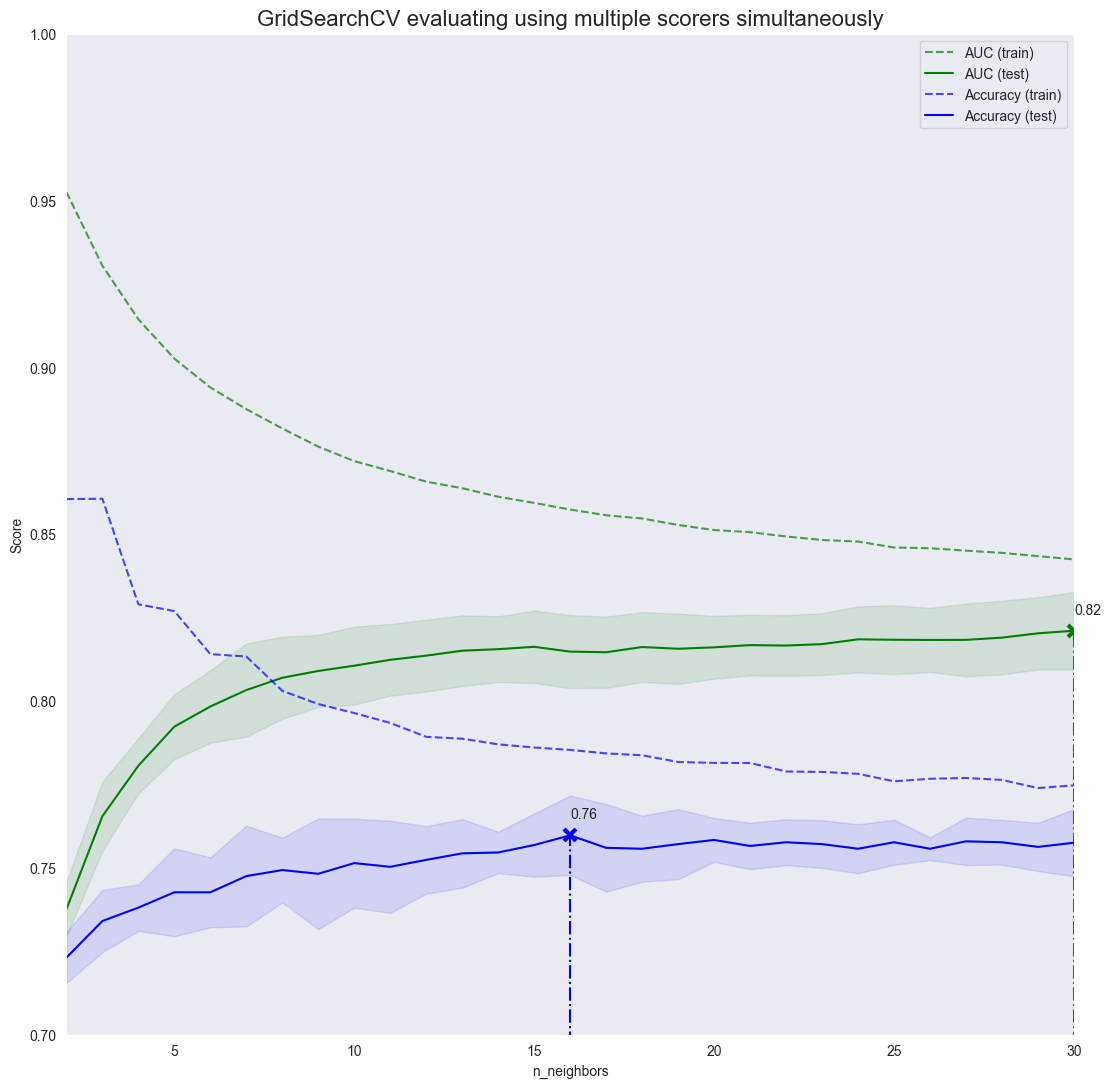

In [163]:
from sklearn.metrics import make_scorer, accuracy_score

# Define the scorers
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

n_neighbours_param_min = 2
n_neighbours_param_max = 31

# Define the parameter grid
param_grid = {"n_neighbors": range(n_neighbours_param_min, n_neighbours_param_max, 1)}

# Initialize GridSearchCV
gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)

# Fit the model
gs.fit(X_train, y_train)
results = gs.cv_results_

# Plot the results
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_neighbors")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(n_neighbours_param_min, n_neighbours_param_max-1)
ax.set_ylim(0.7, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_n_neighbors"].data, dtype=int)
colors = ["g", "b", "r", "y", "m", "k"]

for scorer, color in zip(sorted(scoring), colors[:len(scoring)]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [164]:
# Forward feature selection with hyperparameter tuning
best_subset, best_params, best_score = forward_feat_selection_hypertuning(X_train, y_train)

print("Best subset of features:", best_subset)
print("Best hyperparameters:", best_params)
print("Best model accuracy:", best_score)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best subset: ['occupation_Construction/Extraction', 'occupation_Counseling/Mental Health Services', 'occupation_Education', 'occupation_Entertainment', 'occupation_Farming, Fishing, Forestry', 'occupation_Finance/Accounting', 'occupation_Healthcare/Medical Services', 'occupation_Legal Services', 'occupation_Management/Business', 'occupation_Military Services', 'occupation_Office/Administrative Support', 'occupation_Production/Assembly', 'occupation_Protective Services', 'occupation_Repair/Maintenance', 'occupation_Sales', 'occupation_Science, Engineering, Technology', 'occupation_Service/Hospitality', 'occupation_T

In [165]:
# Use the best subset and best hyperparameters for final model
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train[best_subset], y_train)
final_model_preds = final_model.predict(X_test[best_subset])
final_model_accuracy = accuracy_score(y_test, final_model_preds)

print(classification_report(y_test, final_model_preds))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1175
           1       0.67      0.60      0.64       625

    accuracy                           0.76      1800
   macro avg       0.74      0.72      0.73      1800
weighted avg       0.76      0.76      0.76      1800


In [166]:
# Saving the model
save_model(final_model, '../output/saved_models/knn_model.joblib')